In [63]:
import torch
import trimesh
import pyrender
import numpy as np
import open3d as o3d
from pyrender.trackball import Trackball
from scipy.spatial.transform import Rotation as R
from peract.agent import PerceiverIO, PerceiverActorAgent
from utils.transforms import create_pcd_hardcode
from dataset import InstructionEmbedding
from train_peract import create_lang_encoder
from matplotlib import pyplot as plt
%matplotlib inline
TASK_OFFSET_BOUNDS = [-0.63, 0, -0.63, 0.63, 1.26, 0.63]
CAMERAS = ['front', 'base', 'left', 'wrist_bottom', 'wrist']
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SINGLE_CAMERA = 'left'

In [64]:
# visualization tools for peract

def _compute_initial_camera_pose(scene):
    # Adapted from:
    # https://github.com/mmatl/pyrender/blob/master/pyrender/viewer.py#L1032
    centroid = scene.centroid
    scale = scene.scale
    # if scale == 0.0:
    #     scale = DEFAULT_SCENE_SCALE
    scale = 4.0
    s2 = 1.0 / np.sqrt(2.0)
    cp = np.eye(4)
    # cp[:3, :3] = np.array([[0.0, -s2, s2], [1.0, 0.0, 0.0], [0.0, s2, s2]])
    # cp[:3, :3] = np.array([[-1, 0, 0], [0, -s2, -s2], [0, -s2, s2]])
    # cp[:3, :3] = np.array([[0, 0, 1.0], [0, -1.0, 0], [1.0, 0, 0]])
    # cp[:3, :3] = np.array([[-1.0, 0, 0], [0, -1.0, 0], [0, 0, 1.0]])
    cp[:3, :3] = np.array([[0, 0, -1.0], [0, -1.0, 0], [-1.0, 0, 0]])
    hfov = np.pi / 6.0
    dist = scale / (2.0 * np.tan(hfov))
    # cp[:3, 3] = dist * np.array([1.0, 0.0, 1.0]) + centroid
    # cp[:3, 3] = dist * np.array([0, -1, 1]) + centroid
    # cp[:3, 3] = dist * np.array([1.5, 0, 0.25]) + centroid
    # cp[:3, 3] = dist * np.array([0, 0, 1]) + centroid
    cp[:3, 3] = dist * np.array([-1, 0, 0]) + centroid
    return cp


def _from_trimesh_scene(
        trimesh_scene, bg_color=None, ambient_light=None):
    # convert trimesh geometries to pyrender geometries
    geometries = {name: pyrender.Mesh.from_trimesh(geom, smooth=False)
                  for name, geom in trimesh_scene.geometry.items()}
    # create the pyrender scene object
    scene_pr = pyrender.Scene(bg_color=bg_color, ambient_light=ambient_light)
    # add every node with geometry to the pyrender scene
    for node in trimesh_scene.graph.nodes_geometry:
        pose, geom_name = trimesh_scene.graph[node]
        scene_pr.add(geometries[geom_name], pose=pose)
    return scene_pr


def _create_bounding_box(scene, voxel_size, res):
    l = voxel_size * res
    T = np.eye(4)
    w = 0.01
    for trans in [[0, 0, l / 2], [0, l, l / 2], [l, l, l / 2], [l, 0, l / 2]]:
        T[:3, 3] = np.array(trans) - voxel_size / 2
        scene.add_geometry(trimesh.creation.box(
            [w, w, l], T, face_colors=[0, 0, 0, 255]))
    for trans in [[l / 2, 0, 0], [l / 2, 0, l], [l / 2, l, 0], [l / 2, l, l]]:
        T[:3, 3] = np.array(trans) - voxel_size / 2
        scene.add_geometry(trimesh.creation.box(
            [l, w, w], T, face_colors=[0, 0, 0, 255]))
    for trans in [[0, l / 2, 0], [0, l / 2, l], [l, l / 2, 0], [l, l / 2, l]]:
        T[:3, 3] = np.array(trans) - voxel_size / 2
        scene.add_geometry(trimesh.creation.box(
            [w, l, w], T, face_colors=[0, 0, 0, 255]))


def create_voxel_scene(
        voxel_grid: np.ndarray,
        q_attention: np.ndarray = None,
        highlight_coordinate: np.ndarray = None,
        highlight_gt_coordinate: np.ndarray = None,
        highlight_alpha: float = 1.0,
        voxel_size: float = 0.1,
        show_bb: bool = False,
        alpha: float = 0.5):
    _, d, h, w = voxel_grid.shape
    v = voxel_grid.transpose((1, 2, 3, 0))
    occupancy = v[:, :, :, -1] != 0
    alpha = np.expand_dims(np.full_like(occupancy, alpha, dtype=np.float32), -1)
    rgb = np.concatenate([(v[:, :, :, 3:6] + 1)/ 2.0, alpha], axis=-1)

    if q_attention is not None:
        q = np.max(q_attention, 0)
        q = q / np.max(q)
        show_q = (q > 0.75)
        occupancy = (show_q + occupancy).astype(bool)
        q = np.expand_dims(q - 0.5, -1)  # Max q can be is 0.9
        q_rgb = np.concatenate([
            q, np.zeros_like(q), np.zeros_like(q),
            np.clip(q, 0, 1)], axis=-1)
        rgb = np.where(np.expand_dims(show_q, -1), q_rgb, rgb)

    if highlight_coordinate is not None:
        x, y, z = highlight_coordinate
        occupancy[x, y, z] = True
        rgb[x, y, z] = [1.0, 0.0, 0.0, highlight_alpha]

    if highlight_gt_coordinate is not None:
        x, y, z = highlight_gt_coordinate
        occupancy[x, y, z] = True
        rgb[x, y, z] = [0.0, 0.0, 1.0, highlight_alpha]

    transform = trimesh.transformations.scale_and_translate(
        scale=voxel_size, translate=(0.0, 0.0, 0.0))
    trimesh_voxel_grid = trimesh.voxel.VoxelGrid(
        encoding=occupancy, transform=transform)
    geometry = trimesh_voxel_grid.as_boxes(colors=rgb)
    scene = trimesh.Scene()
    scene.add_geometry(geometry)
    if show_bb:
        assert d == h == w
        _create_bounding_box(scene, voxel_size, d)
    return scene


def visualise_voxel(voxel_grid: np.ndarray,
                    q_attention: np.ndarray = None,
                    highlight_coordinate: np.ndarray = None,
                    highlight_gt_coordinate: np.ndarray = None,
                    highlight_alpha: float = 1.0,
                    rotation_amount: float = 0.0,
                    show: bool = False,
                    voxel_size: float = 0.1,
                    offscreen_renderer: pyrender.OffscreenRenderer = None,
                    show_bb: bool = False,
                    alpha: float = 0.5,
                    render_gripper=False,
                    gripper_pose=None,
                    gripper_mesh_scale=1.0):
    scene = create_voxel_scene(
        voxel_grid, q_attention, highlight_coordinate, highlight_gt_coordinate,
        highlight_alpha, voxel_size,
        show_bb, alpha)
    if show:
        scene.show()
    else:
        r = offscreen_renderer or pyrender.OffscreenRenderer(
            viewport_width=1080, viewport_height=1080, point_size=1.0)
        s = _from_trimesh_scene(
            scene, ambient_light=[0.8, 0.8, 0.8],
            bg_color=[1.0, 1.0, 1.0])
        cam = pyrender.PerspectiveCamera(
            yfov=np.pi / 4.0, aspectRatio=r.viewport_width/r.viewport_height)
        p = _compute_initial_camera_pose(s)
        t = Trackball(p, (r.viewport_width, r.viewport_height), s.scale, s.centroid)
        t.rotate(rotation_amount, np.array([0.0, 0.0, 1.0]))
        s.add(cam, pose=t.pose)

        if render_gripper:
            gripper_trimesh = trimesh.load('/mnt/huangjiangyong/VRKitchen/hand.dae', force='mesh')
            gripper_trimesh.vertices *= gripper_mesh_scale
            radii = np.linalg.norm(gripper_trimesh.vertices - gripper_trimesh.center_mass, axis=1)
            gripper_trimesh.visual.vertex_colors = trimesh.visual.interpolate(radii * gripper_mesh_scale, color_map='winter')
            gripper_mesh = pyrender.Mesh.from_trimesh(gripper_trimesh, poses=np.array([gripper_pose]), smooth=False)
            s.add(gripper_mesh)
        color, depth = r.render(s)
        return color.copy()


def get_gripper_render_pose(voxel_scale, scene_bound_origin, continuous_trans, continuous_quat):
	# finger tip to gripper offset
	offset = np.array([[1, 0, 0, 0],
	                   [0, 1, 0, 0],
	                   [0, 0, 1, 0.1*voxel_scale],
	                   [0, 0, 0, 1]])


	# scale and translate by origin
	translation = (continuous_trans - (np.array(scene_bound_origin[:3]))) * voxel_scale
	mat = np.eye(4,4)
	mat[:3,:3] = R.from_quat([continuous_quat[0], continuous_quat[1], continuous_quat[2], continuous_quat[3]]).as_matrix()
	offset_mat = np.matmul(mat, offset)
	mat[:3,3] = translation - offset_mat[:3,3]
	return mat


def visualize_voxel_grid(voxel_grid, q_trans=None, pred_vox=None, gt_vox=None, render_gripper=False, pred_pos=None, pred_quat=None, rotation_amount=180):
    voxel_size = 0.02
    voxel_scale = voxel_size * 100
    if render_gripper:
        gripper_pose_mat = get_gripper_render_pose(
            voxel_scale, TASK_OFFSET_BOUNDS[:3], pred_pos, pred_quat
        )
    else:
        gripper_pose_mat = None

    rendered_img = visualise_voxel(
        voxel_grid=voxel_grid, q_attention=q_trans, highlight_coordinate=pred_vox, highlight_gt_coordinate=gt_vox, voxel_size=voxel_size, show_bb=False,
        rotation_amount=np.deg2rad(rotation_amount), render_gripper=render_gripper, gripper_pose=gripper_pose_mat, gripper_mesh_scale=voxel_scale
    )

    plt.figure(figsize=(15,15))
    plt.imshow(rendered_img)
    plt.axis('off')

In [65]:
def create_model(ckpt_path):
    perceiver_encoder = PerceiverIO(
        depth=6,
        iterations=1,
        voxel_size=120,
        initial_dim=3 + 3 + 1 + 3,
        low_dim_size=4,
        layer=0,
        num_rotation_classes=72,
        num_grip_classes=2,
        num_state_classes=2,
        num_latents=512,
        latent_dim=512,
        cross_heads=1,
        latent_heads=8,
        cross_dim_head=64,
        latent_dim_head=64,
        weight_tie_layers=False,
        activation='lrelu',
        input_dropout=0.1,
        attn_dropout=0.1,
        decoder_dropout=0.0,
        voxel_patch_size=5,
        voxel_patch_stride=5,
        final_dim=64,
        lang_embed_dim=512,
        with_language=True
    )

    peract_agent = PerceiverActorAgent(
        coordinate_bounds=TASK_OFFSET_BOUNDS,
        perceiver_encoder=perceiver_encoder,
        camera_names=CAMERAS,
        batch_size=1,
        voxel_size=120,
        voxel_feature_size=3,
        num_rotation_classes=72,
        rotation_resolution=5,
        lr=0.0001,
        image_resolution=[128, 128],
        lambda_weight_l2=0.000001,
        transform_augmentation=False,
        optimizer_type='lamb',
    )

    peract_agent.build(training=False, device=DEVICE)
    peract_agent.load_model(ckpt_path)
    
    lang_encoder = create_lang_encoder(encoder_key='clip', device=DEVICE)
    lang_embed_cache = InstructionEmbedding(lang_encoder)

    return peract_agent, lang_embed_cache


@torch.no_grad()
def predict(agent, points, colors, instruction, lang_embed_cache, timestep, camera):
    lang_goal_embs = lang_embed_cache.get_lang_embed(instruction)

    if timestep == 0:
        gripper_open = True
        gripper_joint_positions = [0.04, 0.04]
    elif timestep == 1:
        gripper_open = False
        gripper_joint_positions = [0, 0]
    low_dim_state = np.array([gripper_open, *gripper_joint_positions, timestep]).reshape(1, -1)

    input_dict = {
        'lang_goal_embs': lang_goal_embs,
        'low_dim_state': low_dim_state,
    }

    obs_dict = {}
    print(f'receive observation at shape {points.shape}')
    if camera == 'single':
        if points.ndim == 2:
            points = points[None, None, ...]
            colors = colors[None, None, ...]
        elif points.ndim == 3:
            points = points[None, ...]
            colors = colors[None, ...]
        for n in CAMERAS:
            if n == SINGLE_CAMERA:
                obs_dict[f'{n}_rgb'] = colors.transpose(0, 3, 1, 2)   # peract requires input as CHW
                obs_dict[f'{n}_point_cloud'] = points.transpose(0, 3, 1, 2)   # peract requires input as CHW
            else:
                obs_dict[f'{n}_rgb'] = np.zeros((1, 3, 0, 0))   # peract requires input as CHW
                obs_dict[f'{n}_point_cloud'] = np.zeros((1, 3, 0, 0))   # peract requires input as CHW
    else:
        for n, rgb, pcd in zip(CAMERAS, colors, points):
            rgb = rgb[None, ...]
            pcd = pcd[None, ...]
            obs_dict[f'{n}_rgb'] = rgb.transpose(0, 3, 1, 2)   # peract requires input as CHW
            obs_dict[f'{n}_point_cloud'] = pcd.transpose(0, 3, 1, 2)   # peract requires input as CHW

    input_dict.update(obs_dict)

    for k, v in input_dict.items():
        if v is not None:
            if not isinstance(v, torch.Tensor):
                v = torch.from_numpy(v)
            input_dict[k] = v.to(DEVICE)

    output_dict = agent.predict(input_dict)
    target_voxel = output_dict['pred_action']['trans'][0].detach().cpu().numpy()
    position = output_dict['pred_action']['continuous_trans'].detach().cpu().numpy()
    print(f"timestep {timestep}: {target_voxel}, {position}")
    rotation = output_dict['pred_action']['continuous_quat']
    # rotation = rotation[[3,0,1,2]]   # xyzw to wxyz
    return target_voxel, position, rotation, output_dict['voxel_grid'][0].detach().cpu().numpy()


def visualize_pos(scene_pcd, pos):
    cube_points = [
        pos + np.array([-0.05, -0.05, -0.05]),
        pos + np.array([0.05, -0.05, -0.05]),
        pos + np.array([-0.05, 0.05, -0.05]),
        pos + np.array([0.05, 0.05, -0.05]),
        pos + np.array([-0.05, -0.05, 0.05]),
        pos + np.array([0.05, -0.05, 0.05]),
        pos + np.array([-0.05, 0.05, 0.05]),
        pos + np.array([0.05, 0.05, 0.05])
    ]
    cube_lines = [
        [0, 1],
        [0, 2],
        [1, 3],
        [2, 3],
        [4, 5],
        [4, 6],
        [5, 7],
        [6, 7],
        [0, 4],
        [1, 5],
        [2, 6],
        [3, 7]
    ]
    cube = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(cube_points),
        lines=o3d.utility.Vector2iVector(cube_lines)
    )
    cube.colors = o3d.utility.Vector3dVector([[1, 0, 0] for i in range(len(cube_lines))])
    o3d.visualization.draw_geometries([scene_pcd, cube])


def act_on_demo_step(step, agent, lang_embed_cache, timestep, full_obs=True):
    robot_forward_direction = R.from_quat(step['robot_base'][1][[1,2,3,0]]).as_matrix()[:, 0]
    robot_forward_direction[1] = 0
    robot_forward_direction = robot_forward_direction / np.linalg.norm(robot_forward_direction) * 0.5   # m
    bound_center = step['robot_base'][0] / 100 + robot_forward_direction

    instruction = step['instruction']
    print(f'Instruction: {instruction}')

    imgs = step['images']
    points = []
    colors = []
    for camera_obs in imgs:
        camera = camera_obs['camera']
        color = camera_obs['rgb'][:, :, :3]   # int [0, 255]
        depth = np.clip(camera_obs['depthLinear'], 0, 10)
        point_cloud = create_pcd_hardcode(camera, depth, cm_to_m=True)
        # here point_cloud is y-up and in meter
        point_cloud = point_cloud - bound_center
        # supposed to be located in TASK_OFFSET_BOUNDS
        points.append(point_cloud)

        colors.append(color)
        plt.figure()
        # show each partial obs
        plt.subplot(1, 2, 1)
        plt.imshow(color)
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(depth / 10)
        plt.axis('off')
    
    points = np.stack(points)
    points[..., 0::2] = np.clip(points[..., 0::2], -0.63, 0.63)
    points[..., 1] = np.clip(points[..., 1], 0, 1.26)
    colors = np.stack(colors)

    if full_obs:
        pred_vox, pred_pos, pred_quat, voxel_grid = predict(agent, points, colors, instruction, lang_embed_cache, timestep, camera='multi')
    else:
        camera_idx = CAMERAS.index(SINGLE_CAMERA)
        pred_vox, pred_pos, pred_quat, voxel_grid = predict(agent, points[camera_idx], colors[camera_idx], instruction, lang_embed_cache, timestep, camera='single')

    print(f'absolute position: {pred_pos + bound_center}')

    visualize_voxel_grid(voxel_grid, q_trans=None, pred_vox=pred_vox, render_gripper=True, pred_pos=pred_pos, pred_quat=pred_quat)

    scene_pcd = o3d.geometry.PointCloud()
    scene_pcd.points = o3d.utility.Vector3dVector(points.reshape(-1, 3))
    scene_pcd.colors = o3d.utility.Vector3dVector(colors.reshape(-1, 3) / 255)
    visualize_pos(scene_pcd, pred_pos)


def act_on_ply(ply_path, agent, lang_embed_cache, instruction, timestep, bound_center):
    scene_pcd = o3d.io.read_point_cloud(ply_path)
    # scene_pcd = scene_pcd.voxel_down_sample(voxel_size=0.004)

    points = np.asarray(scene_pcd.points)
    colors = np.asarray(scene_pcd.colors)

    # process with bound
    # bound_min = np.min(points, axis=0)
    # bound_max = np.max(points, axis=0)
    # bound_center = (bound_min + bound_max) / 2
    
    points -= np.array(bound_center)
    points[..., 0::2] = np.clip(points[..., 0::2], -0.63, 0.63)
    points[..., 1] = np.clip(points[..., 1], 0, 1.26)
    if colors.max() < 1.5:
        colors = np.clip(colors*255, 0, 255).astype(np.uint8)

    pred_vox, pred_pos, pred_quat, voxel_grid = predict(agent, points, colors, instruction, lang_embed_cache, timestep, camera='single')
    print(f'absolute position: {pred_pos + bound_center}')

    scene_pcd = o3d.geometry.PointCloud()
    scene_pcd.points = o3d.utility.Vector3dVector(points.reshape(-1, 3))
    scene_pcd.colors = o3d.utility.Vector3dVector(colors.reshape(-1, 3) / 255)
    visualize_pos(scene_pcd, pred_pos)

Instruction: drag the top left dresser half open
receive observation at shape (5, 128, 128, 3)
timestep 0: [71 68 42], [ 0.12075003  0.71925    -0.18374994]
absolute position: [ 3.06078013  0.72564    -1.35660996]


W0314 16:38:11.661753 140059319805760 texture.py:222] concatenating texture: may result in visual artifacts


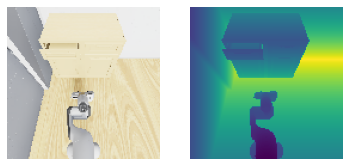

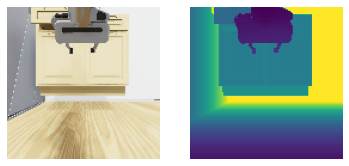

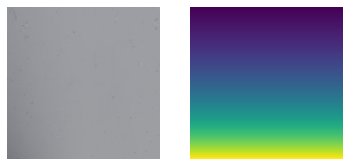

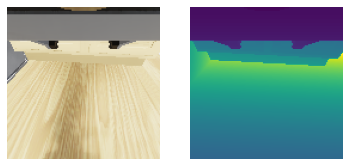

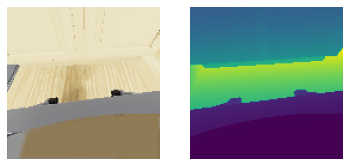

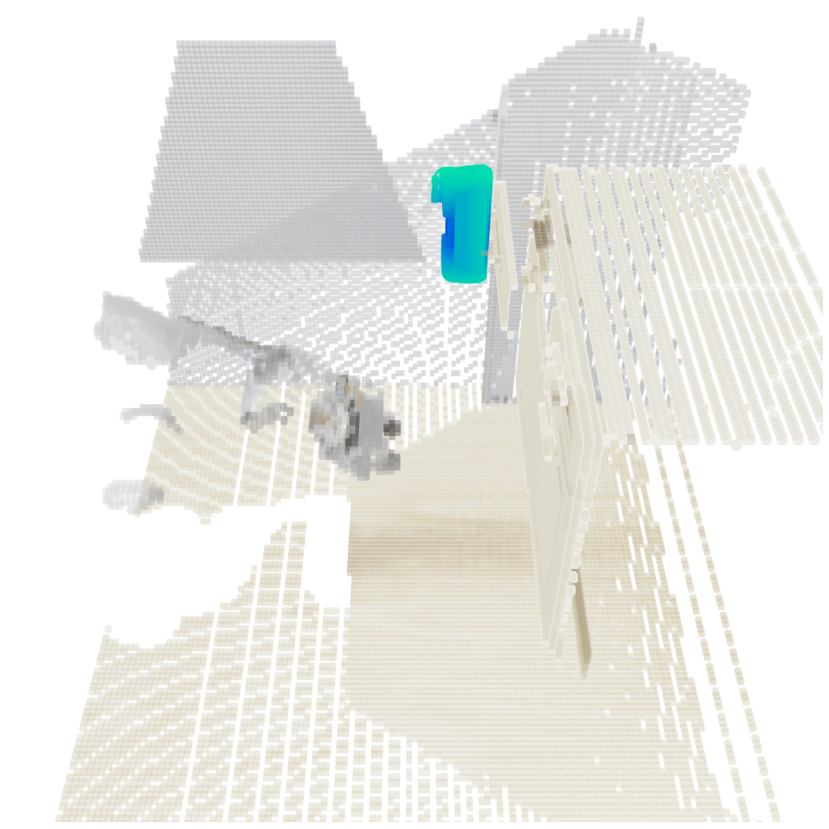

In [4]:
step = np.load('/mnt/huangjiangyong/VRKitchen/open_drawer/test/Steven-open_drawer-1-0-0.25-0.5-15-Mon_Jan_30_06:43:58_2023.npz', allow_pickle=True)['gt'][0]
agent, lang_embed_cache = create_model(ckpt_path='/mnt/huangjiangyong/VRKitchen/open_drawer/ckpt_peract/peract_open_drawer_rgb_clip_best.pth')
act_on_demo_step(step, agent, lang_embed_cache, timestep=0, full_obs=True)

In [ ]:
step = np.load('/mnt/huangjiangyong/VRKitchen/open_drawer/test/Steven-open_drawer-7-0-0.0-0.5-4-Mon_Jan_30_08:10:35_2023.npz', allow_pickle=True)['gt'][0]
agent, lang_embed_cache = create_model(ckpt_path='/mnt/huangjiangyong/VRKitchen/open_drawer/ckpt_peract/peract_open_drawer_rgb_clip_best.pth')
act_on_demo_step(step, agent, lang_embed_cache, timestep=0, full_obs=False)

In [66]:
ply_path = '/home/huangjiangyong/Desktop/pc_real_fps.ply'
agent, lang_embed_cache = create_model(ckpt_path='/mnt/huangjiangyong/VRKitchen/open_drawer/ckpt_peract/peract_open_drawer_rgb_clip_best.pth')
act_on_ply(ply_path, agent, lang_embed_cache, instruction='open the top left drawer 50%', timestep=0, bound_center=(0, 0, 0))

receive observation at shape (81920, 3)
timestep 0: [70 46 64], [0.11025008 0.48825005 0.04725005]
absolute position: [0.11025008 0.48825005 0.04725005]


Instruction: open the  cabinet half
receive observation at shape (5, 128, 128, 3)
timestep 0: [53 60 37], [-0.06824998  0.63525003 -0.23624995]
absolute position: [-2.7813978   0.63528     3.14169229]


W0314 16:38:53.336103 140059319805760 texture.py:222] concatenating texture: may result in visual artifacts


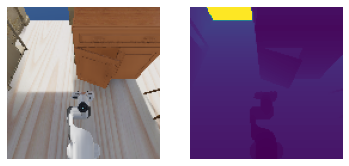

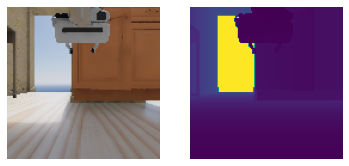

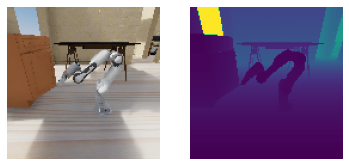

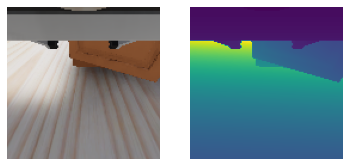

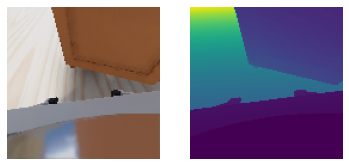

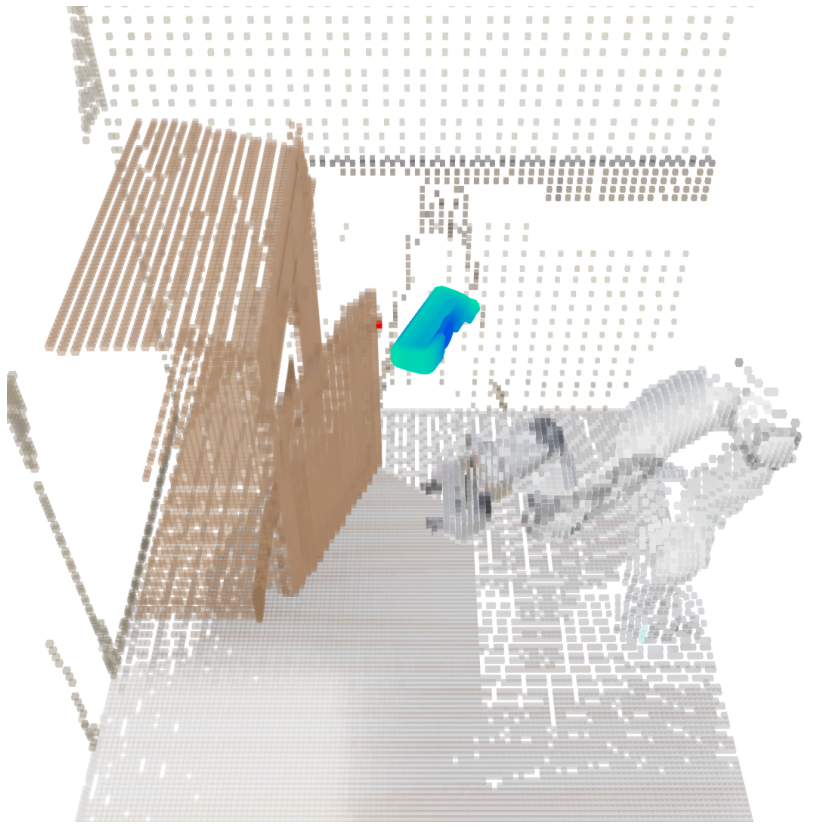

In [5]:
step = np.load('/mnt/huangjiangyong/VRKitchen/demo/open_cabinet/Xiaofeng-open_cabinet-1-0-0.25-0.5-5-Wed_Jan_18_13:43:33_2023.npz', allow_pickle=True)['gt'][0]
agent, lang_embed_cache = create_model(ckpt_path='/mnt/huangjiangyong/VRKitchen/open_cabinet/ckpt_peract_state_clip/peract_open_cabinet_rgb_clip_best.pth')
act_on_demo_step(step, agent, lang_embed_cache, timestep=0, full_obs=True)

W0315 17:52:10.772259 140322327480128 texture.py:222] concatenating texture: may result in visual artifacts


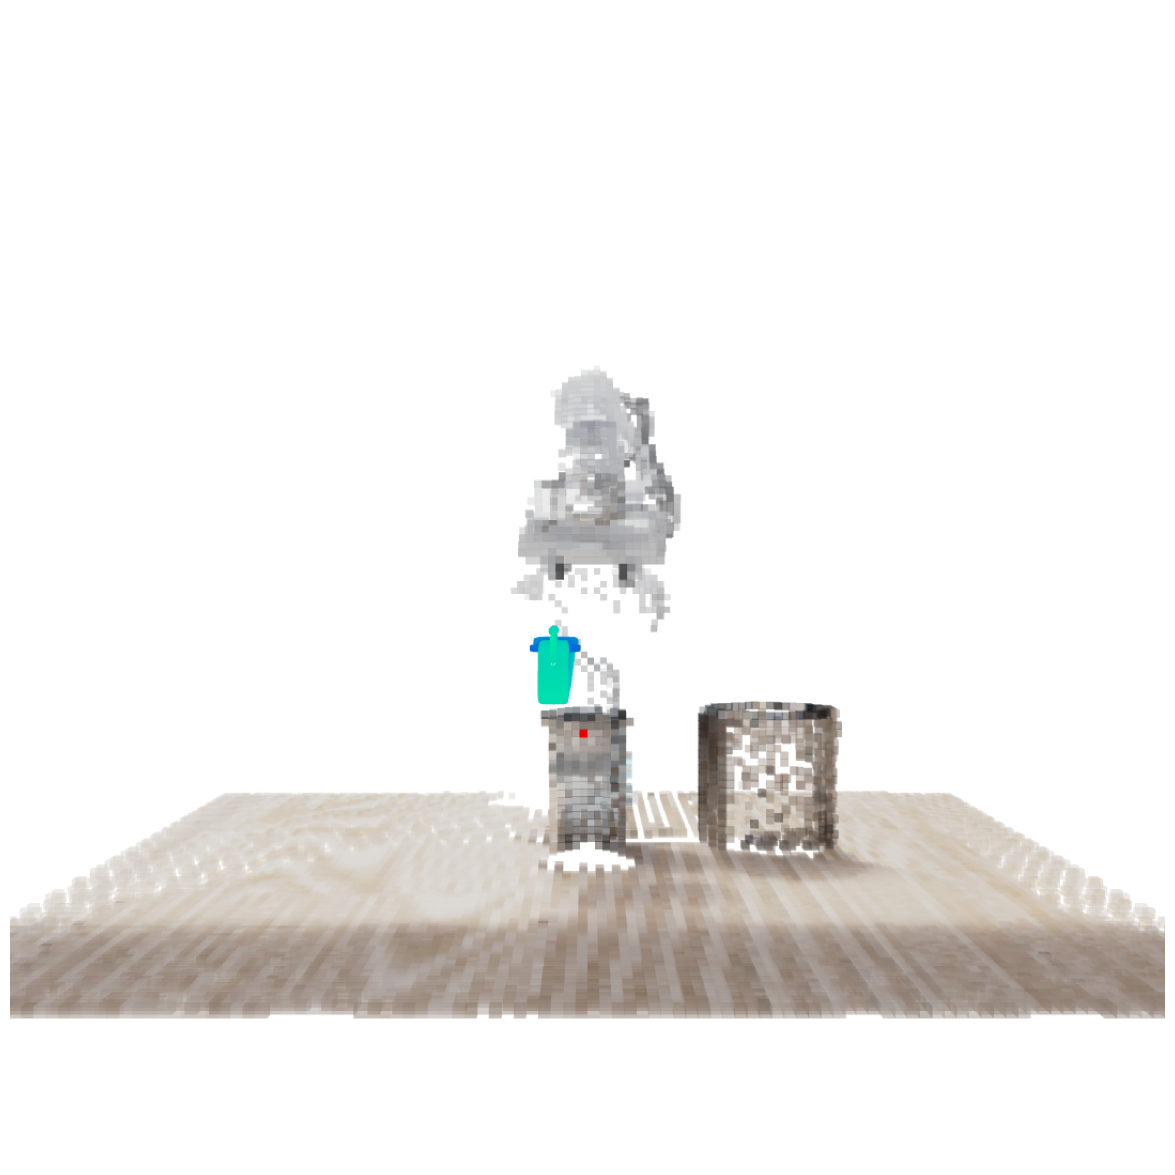

In [60]:
act_0 = np.load('transfer_water_0.npz')
voxel_grid = act_0['voxel_grid']
pred_vox = act_0['pred_vox']
pred_pos = act_0['pred_pos']
pred_quat = act_0['pred_quat']
visualize_voxel_grid(voxel_grid, q_trans=None, pred_vox=pred_vox, render_gripper=True, pred_pos=pred_pos, pred_quat=pred_quat)

W0315 17:52:21.699485 140322327480128 texture.py:222] concatenating texture: may result in visual artifacts


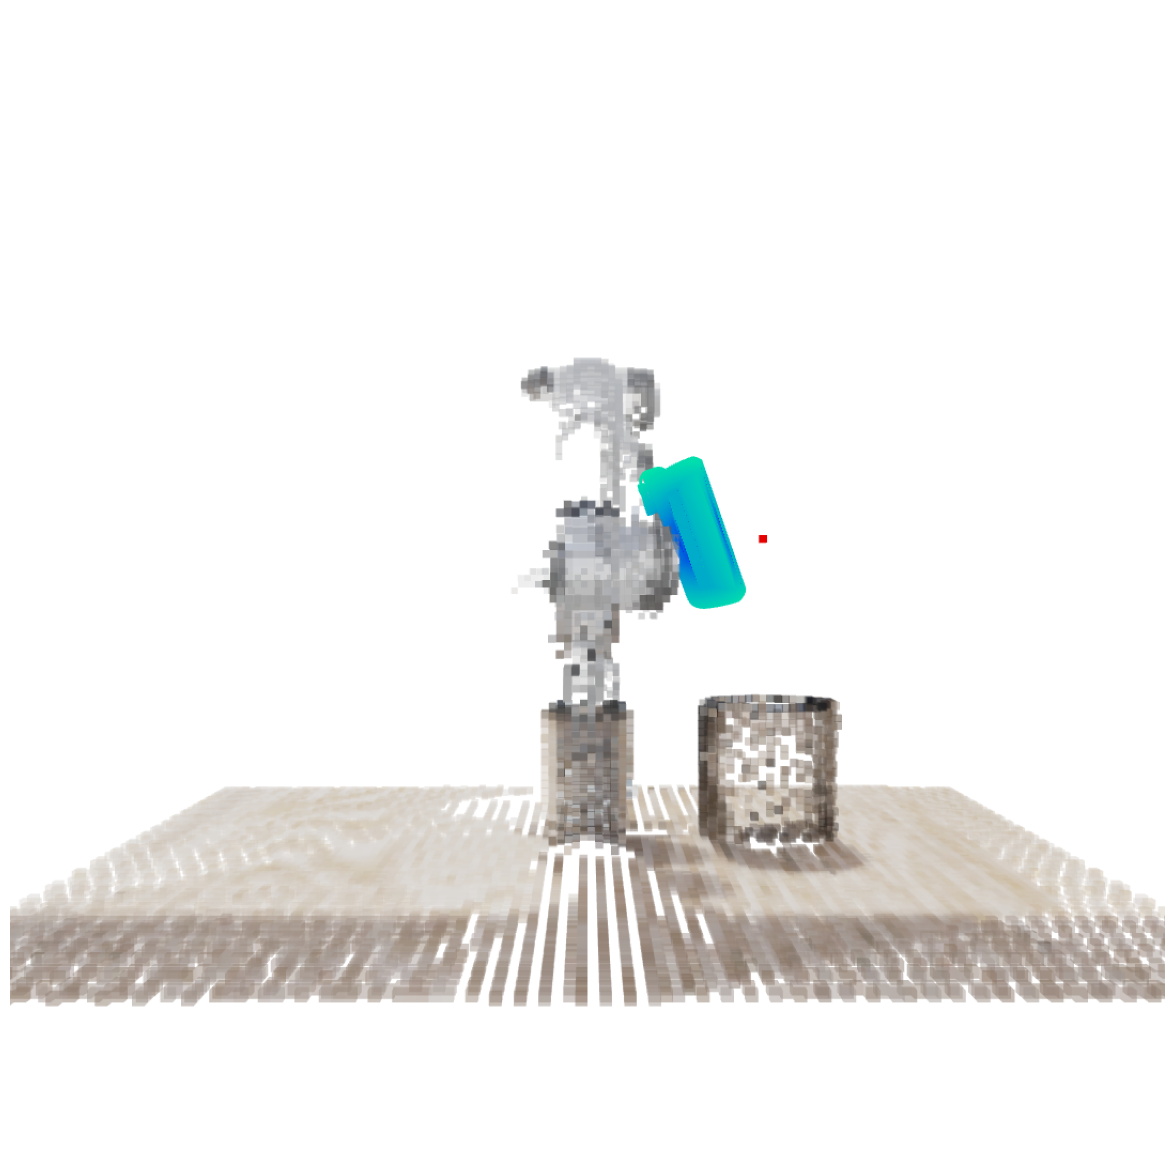

In [61]:
act_1 = np.load('transfer_water_1.npz')
voxel_grid = act_1['voxel_grid']
pred_vox = act_1['pred_vox']
pred_pos = act_1['pred_pos']
pred_quat = act_1['pred_quat']
visualize_voxel_grid(voxel_grid, q_trans=None, pred_vox=pred_vox, render_gripper=True, pred_pos=pred_pos, pred_quat=pred_quat)